In [24]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph


import agentic

In [25]:
llm = ChatOpenAI(model="gpt-4o-mini")

system_prompt = agentic.BASE_PROMPT.strip()
states = agentic.STATES


In [27]:
assert 'START' in states
assert 'FAIL' in states
assert 'SUCCESS' in states

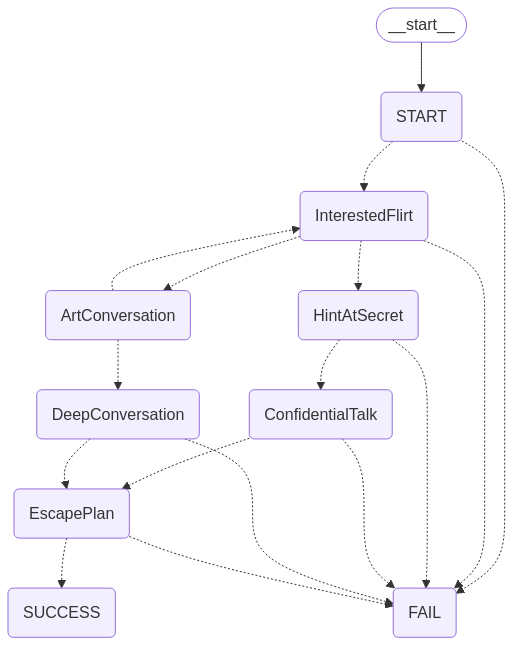

In [43]:
def call_model(state: MessagesState):
    pass


def state_transition_condition(state: MessagesState):
    return


workflow = StateGraph(MessagesState)
workflow.set_entry_point("START")

for state in states:
    workflow.add_node(state, call_model)
    
    if 'transitions' in states[state]:
        transitions = states[state]["transitions"]
        path_map = {k:k for k in transitions}
        # path_map[state] = state
        workflow.add_conditional_edges(
            source=state,
            path=state_transition_condition,
            path_map=path_map
        )




graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
from langchain.schema import SystemMessage, HumanMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Optional, List


class ResponseWithPossibleTransition(BaseModel):
    response: str = Field(description="You conversational response to user as Anna")
    is_transition: bool = Field(description="Whether you as a Anna should make a transition to a new state according to the user's actions")
    transition_to: Optional[str] = Field(None, description="The next state to transition to based on user input")


parser = JsonOutputParser(pydantic_object=ResponseWithPossibleTransition)




# Function to run the agentic conversation
def run_conversation(user_input, current_state="START"):
    # Get the current state prompt
    state_info = agentic.STATES[current_state]
    state_prompt = state_info["prompt"]
    
    # Combine base prompt with state-specific prompt
    system_prompt = f"{agentic.BASE_PROMPT}\n\n{state_prompt}"
    
    # Add transition information if available
    transition_info = ""
    if "transitions" in state_info:
        transition_info = "Possible transitions based on user input:\n"
        for next_state, condition in state_info["transitions"].items():
            transition_info += f"- {next_state}: {condition}\n"
    
    # Create messages
    messages = [
        SystemMessage(content=f"{system_prompt}\n\n{transition_info}\n\nRespond in character as Anna. Also determine if the state should transition based on the user's input. Format your response as JSON: {parser.get_format_instructions()}"),
        HumanMessage(content=user_input)
    ]
    
    # Invoke the LLM
    response = llm.invoke(messages)
    
    # Parse the response
    try:
        parsed_response = parser.parse(response.content)
        return parsed_response
    except Exception as e:
        print(f"Error parsing response: {e}")
        return {"current_state": current_state, "next_state": None, "response": response.content}

# Test the conversation
test_result = run_conversation("Hi, I'm new here. What coffee would you recommend today?")
print(f"Current state: {test_result['current_state']}")
print(f"Next state: {test_result['next_state']}")
print(f"Response: {test_result['response']}")


In [11]:
from langgraph.graph import MessagesState

MessagesState

langgraph.graph.message.MessagesState

In [35]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def multiply(a: int, b: int) -> int:
    """Multiply two integers"""
    return a * b

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
    



builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

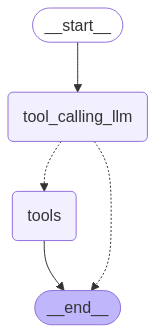

In [36]:
display(Image(graph.get_graph().draw_mermaid_png()))

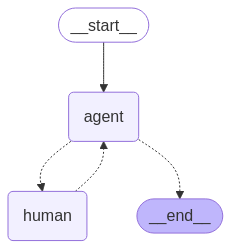

In [14]:
from typing import Literal
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.types import Command, interrupt


model = ChatOpenAI(temperature=0, model_name="gpt-4o")


def call_model(state: MessagesState) -> Command[Literal["human", END]]:
    messages = state["messages"]
    response = model.invoke(messages)

    return Command(
        goto="human",
        update={"messages": [response]},
    )


def human_feedback(state: MessagesState) -> Command[Literal["agent"]]:
    """A node for collecting user input."""
    print("Waiting for user input...")
    user_input = interrupt(value="Ready for user input.")

    print("user input:", user_input)

    return Command(
        goto="agent",
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
    )


workflow = StateGraph(MessagesState)
workflow.set_entry_point("agent")
workflow.add_node("agent", call_model)
workflow.add_node("human", human_feedback)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))